In [1]:
import argparse
import joblib
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import (
    StratifiedKFold,
    cross_val_score,
    cross_val_predict,
    train_test_split,
)
import itertools

from sklearn.pipeline import make_pipeline

# Scalers and classifiers from scikit-learn
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix,recall_score, precision_score,accuracy_score
from sklearn.preprocessing import (
    MaxAbsScaler,
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
)
from sklearn.model_selection import KFold

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(7,7), text_size=8):

  plt.rcParams['figure.dpi'] = 300
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm_norm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f"{cm_norm[i, j]*100:.1f}%",
             horizontalalignment="center",
             size=text_size)

classifiers = {
    "dec_tree": DecisionTreeClassifier(
        max_depth=9,
        min_samples_split=2,
        min_samples_leaf=3,
        splitter="best",
        random_state=0,
    ),
    "rand_for": RandomForestClassifier(
        n_estimators=100, max_depth=10, min_samples_split=2, random_state=0
    ),
    "svm": SVC(gamma="auto", kernel="linear", C=3, probability=True),
    "kneighbors": KNeighborsClassifier(n_neighbors=2, leaf_size=3, weights="distance"),
    "logistic": LogisticRegression(max_iter=10000, random_state=0),
    "neural": MLPClassifier(
        hidden_layer_sizes=(200,), alpha=0.01, max_iter=1000, random_state=0
    ),
}
scalers = {
    "standard": StandardScaler(),
    "minmax": MinMaxScaler(),
    "maxabs": MaxAbsScaler(),
    "robust": RobustScaler(quantile_range=(25, 75)),
}

# Name of the file in which the trained model is saved

# Name of the column with the labels
target = "Target"

# Order of the targets for the confusion matrix
labels = [
    "0",
    "1",
    "2",
    "3",
    "4",
    "5",
    "6","7","8","9"
]

# Shuffle (True) or not (False) the training deck
# shuffle_train = True
def training(train_file, model, scaler, predict=False, split=True, crossval=True):

    print("TRAINING")
    print(f"Training model {model}")
    print(f"Scaler: {scaler}")

    trainset = _load_csv(train_file)

    if trainset is None:
        print(f"{train_file} is not a valid training file or doesn't exist")
        return False

    # Separates the features and the target from the trainset
    X = trainset.drop(target, axis=1)
    y = trainset[target]

    # Split the deck into train and test decks

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.25,random_state=1
    )

    model = classifiers[model]

    if scaler:
        scaler = scalers[scaler]

    # Construct the pipeline
    pipe = make_pipeline(scaler, model)

    # Performs the cross validation
    if crossval:
        cross_validation(X_test, y_test, pipe)
    # Trains the model
    pipe.fit(X_train, y_train)

    # Checking the accuracy with the (hold-out) test set


def cross_validation(X, y, model, shuffle_train=True):
    print("\nCROSS-VALIDATION")
    num_folds = 10
    cv = StratifiedKFold(n_splits=num_folds, shuffle=shuffle_train, random_state=0 if shuffle_train else None)
    kfold = KFold(n_splits=num_folds)

    # Perform cross-validation and calculate average accuracy
    kfoldaccuracy = cross_val_score(model, X, y, cv=kfold, scoring='accuracy')
    # print(f"Cross-validation scores: {results}")
    accuracy = kfoldaccuracy.mean()
    print(f"Cross-validation average accuracy: {accuracy}")

    # Perform cross-validation to get predictions for computing confusion matrix and other metrics
    y_train_pred = cross_val_predict(model, X, y, cv=cv, n_jobs=-1)

    # Calculate and plot confusion matrix
    make_confusion_matrix(y_true=y, y_pred=y_train_pred, classes=['BP','Gr','MoS$_2$','ReS$_2$','Te','WSe$_2$','WTe$_2$','S$_1$','S$_2$','S$_3$'])

    # Calculate and print average precision and recall
    avg_precision = precision_score(y, y_train_pred, average='macro')
    avg_recall = recall_score(y, y_train_pred, average='macro')
    avg_accuracy = accuracy_score(y, y_train_pred)
    print(f"Average Precision: {avg_precision}")
    print(f"Average Recall: {avg_recall}")
    print(f"Average accuracy: {avg_accuracy}")




def predicting(trained_model, predict_file):
    print("PREDICTING")
    print(f"Predict file: {predict_file}")
    print(f"Trained model {trained_model}")

    predict = _load_csv(predict_file)
    model = joblib.load(trained_model)

    # Removes the data that could not be manually determined
    predict = predict[~predict[target].isin(["NotDetermined"])]

    # Separates the test data in features (X) and labels (y, if present)
    if target in predict.columns:
        X_predict = predict.drop(target, axis=1)
        y_predict = predict[target]
    else:
        X_predict = predict
        y_predict = None

    # Performs the prediction
    predict_result = model.predict(X_predict)

    if target in predict.columns:
        accuracy = metrics.accuracy_score(y_predict, predict_result)
        print(f"Prediction accuracy: {accuracy}")

        y_predict = pd.DataFrame(
            y_predict.values.tolist(), columns=["Real value"], index=y_predict.index
        )
        y_predict["Prediction"] = predict_result.tolist()
    else:
        y_predict = pd.DataFrame(predict_result, columns="Prediction")

    # Saves the prediction in a file
    y_predict.to_csv("results/prediction.csv")

D:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def _load_csv(file):
    """Open a csv file and stores it as a pandas dataframe"""

    try:
        with open(file) as f:
            df = pd.read_csv(f, sep=None, engine="python")
            return df
    except Exception as err:
        print(f"Error loading .csv file: {file}")
        print(err)
        sys.exit()

TRAINING
Training model neural
Scaler: robust

CROSS-VALIDATION
Cross-validation average accuracy: 1.0
Average Precision: 1.0
Average Recall: 1.0
Average accuracy: 1.0


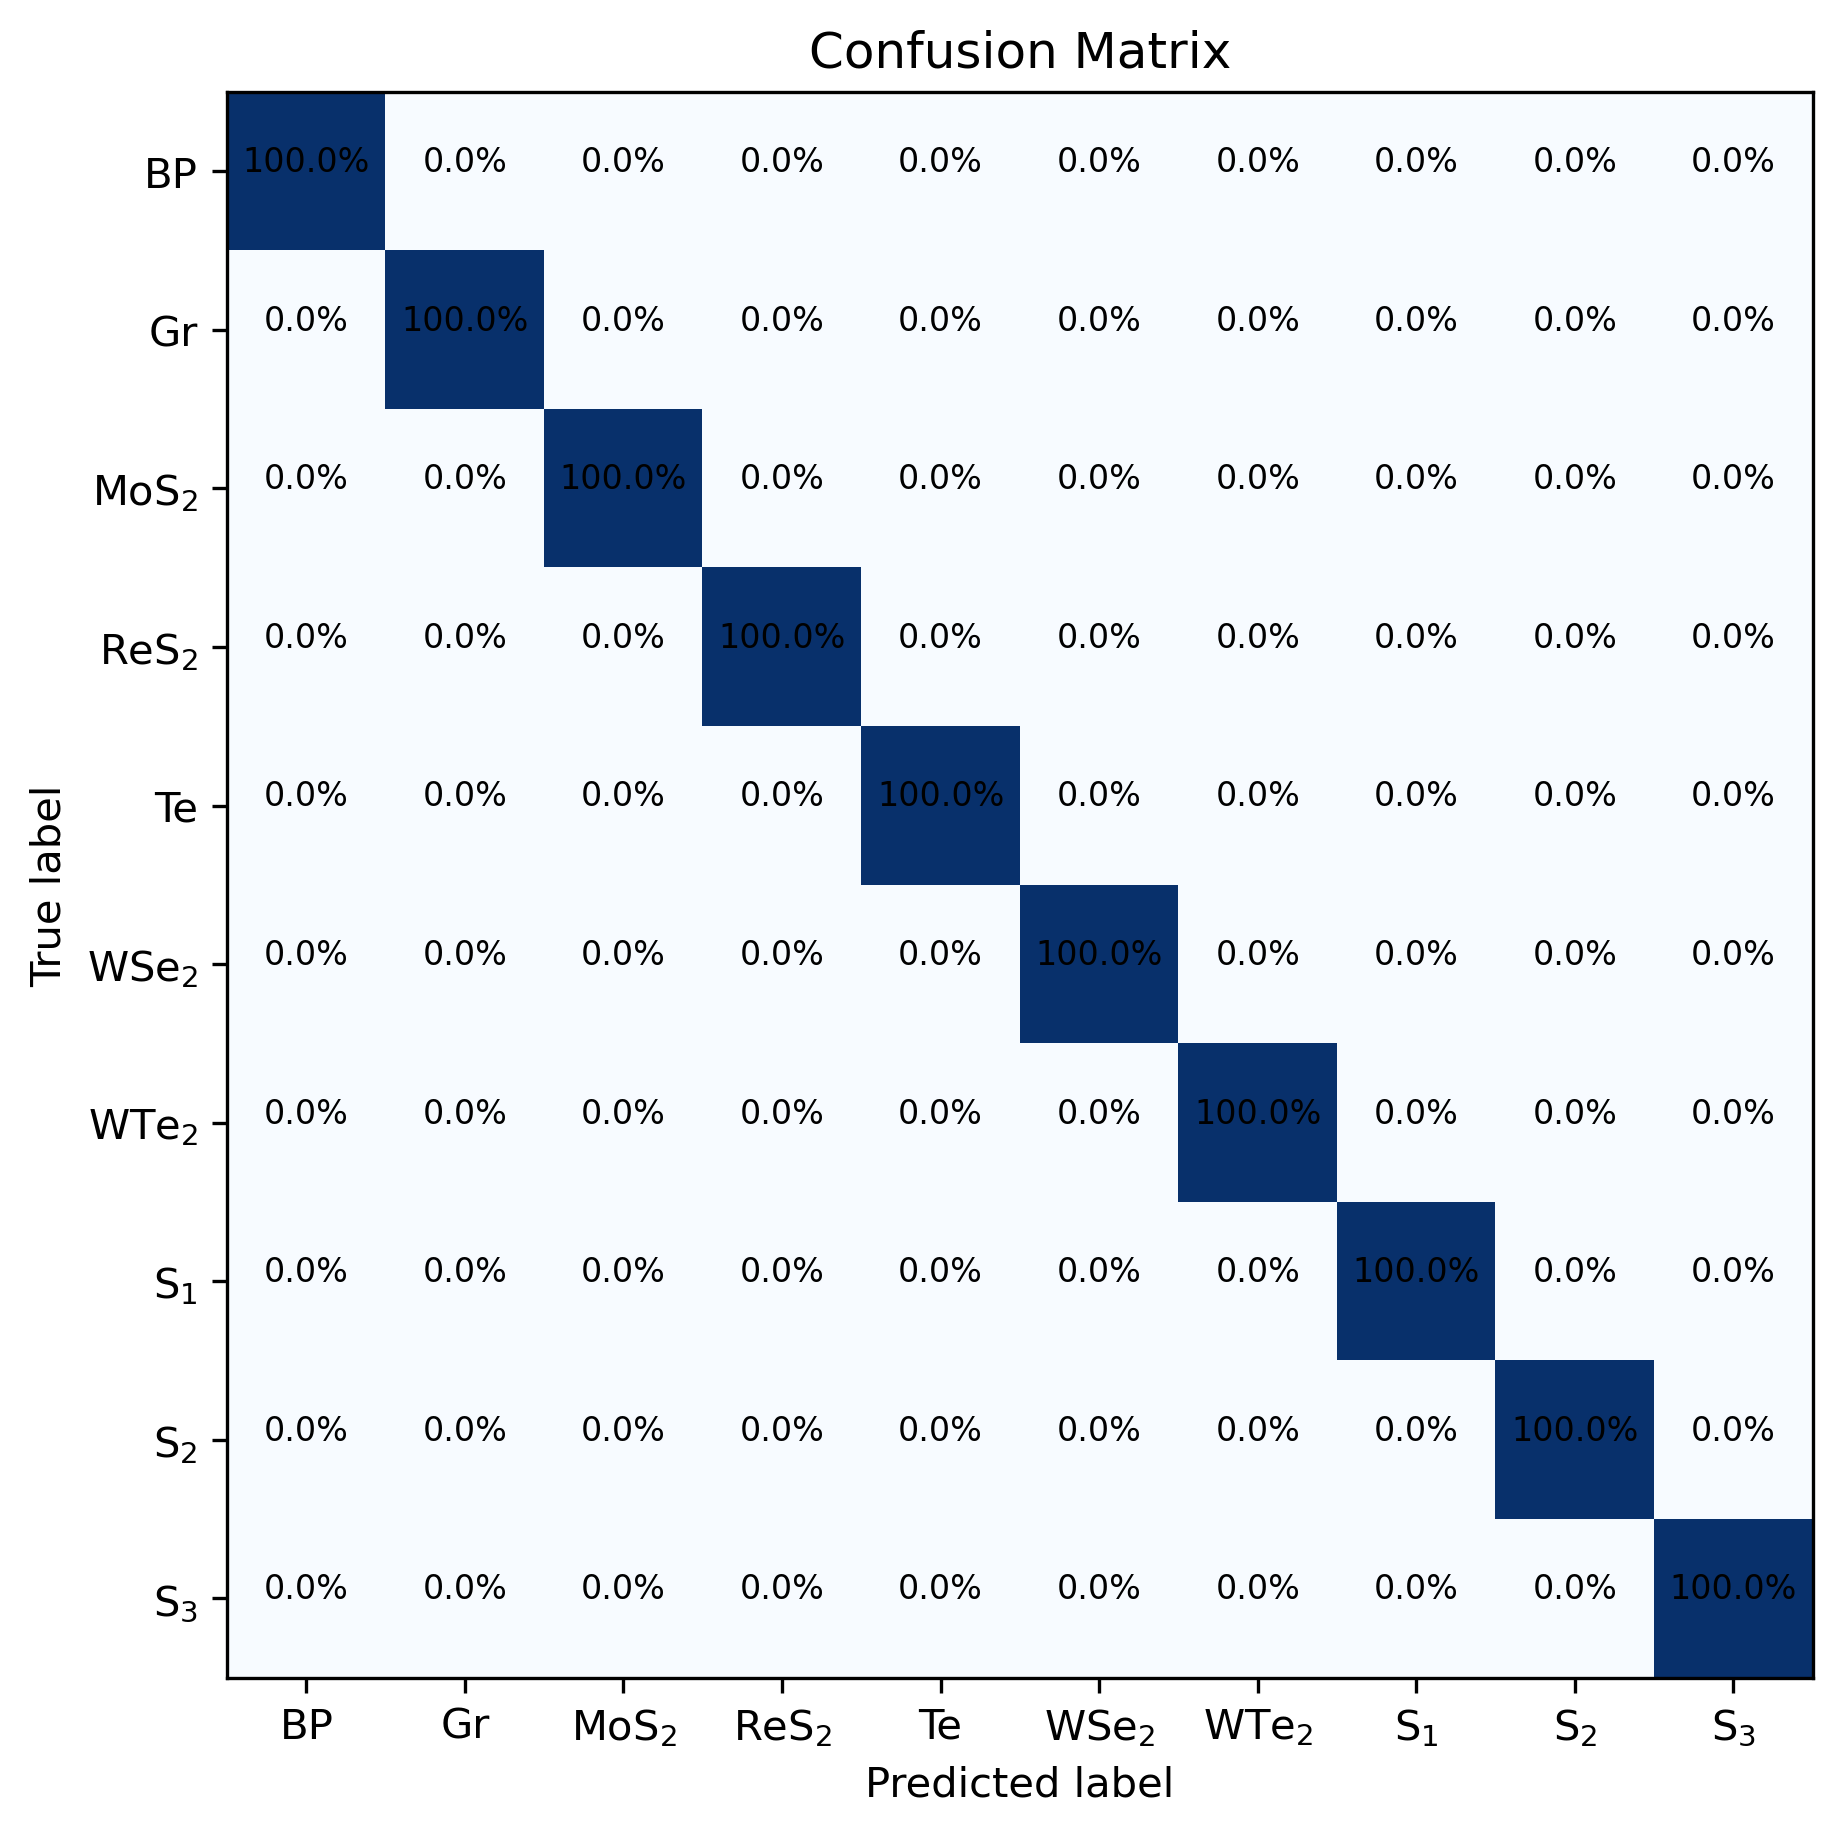

In [3]:
filepath = ('D:\HUDAN_FYP\\tBLG\\2DMaterials\Dataset\\2D\\2D_DDPM1119.csv')
training(filepath, model = 'neural', scaler = 'robust')

TRAINING
Training model rand_for
Scaler: robust

CROSS-VALIDATION
Cross-validation average accuracy: 0.9996
Average Precision: 1.0
Average Recall: 1.0
Average accuracy: 1.0


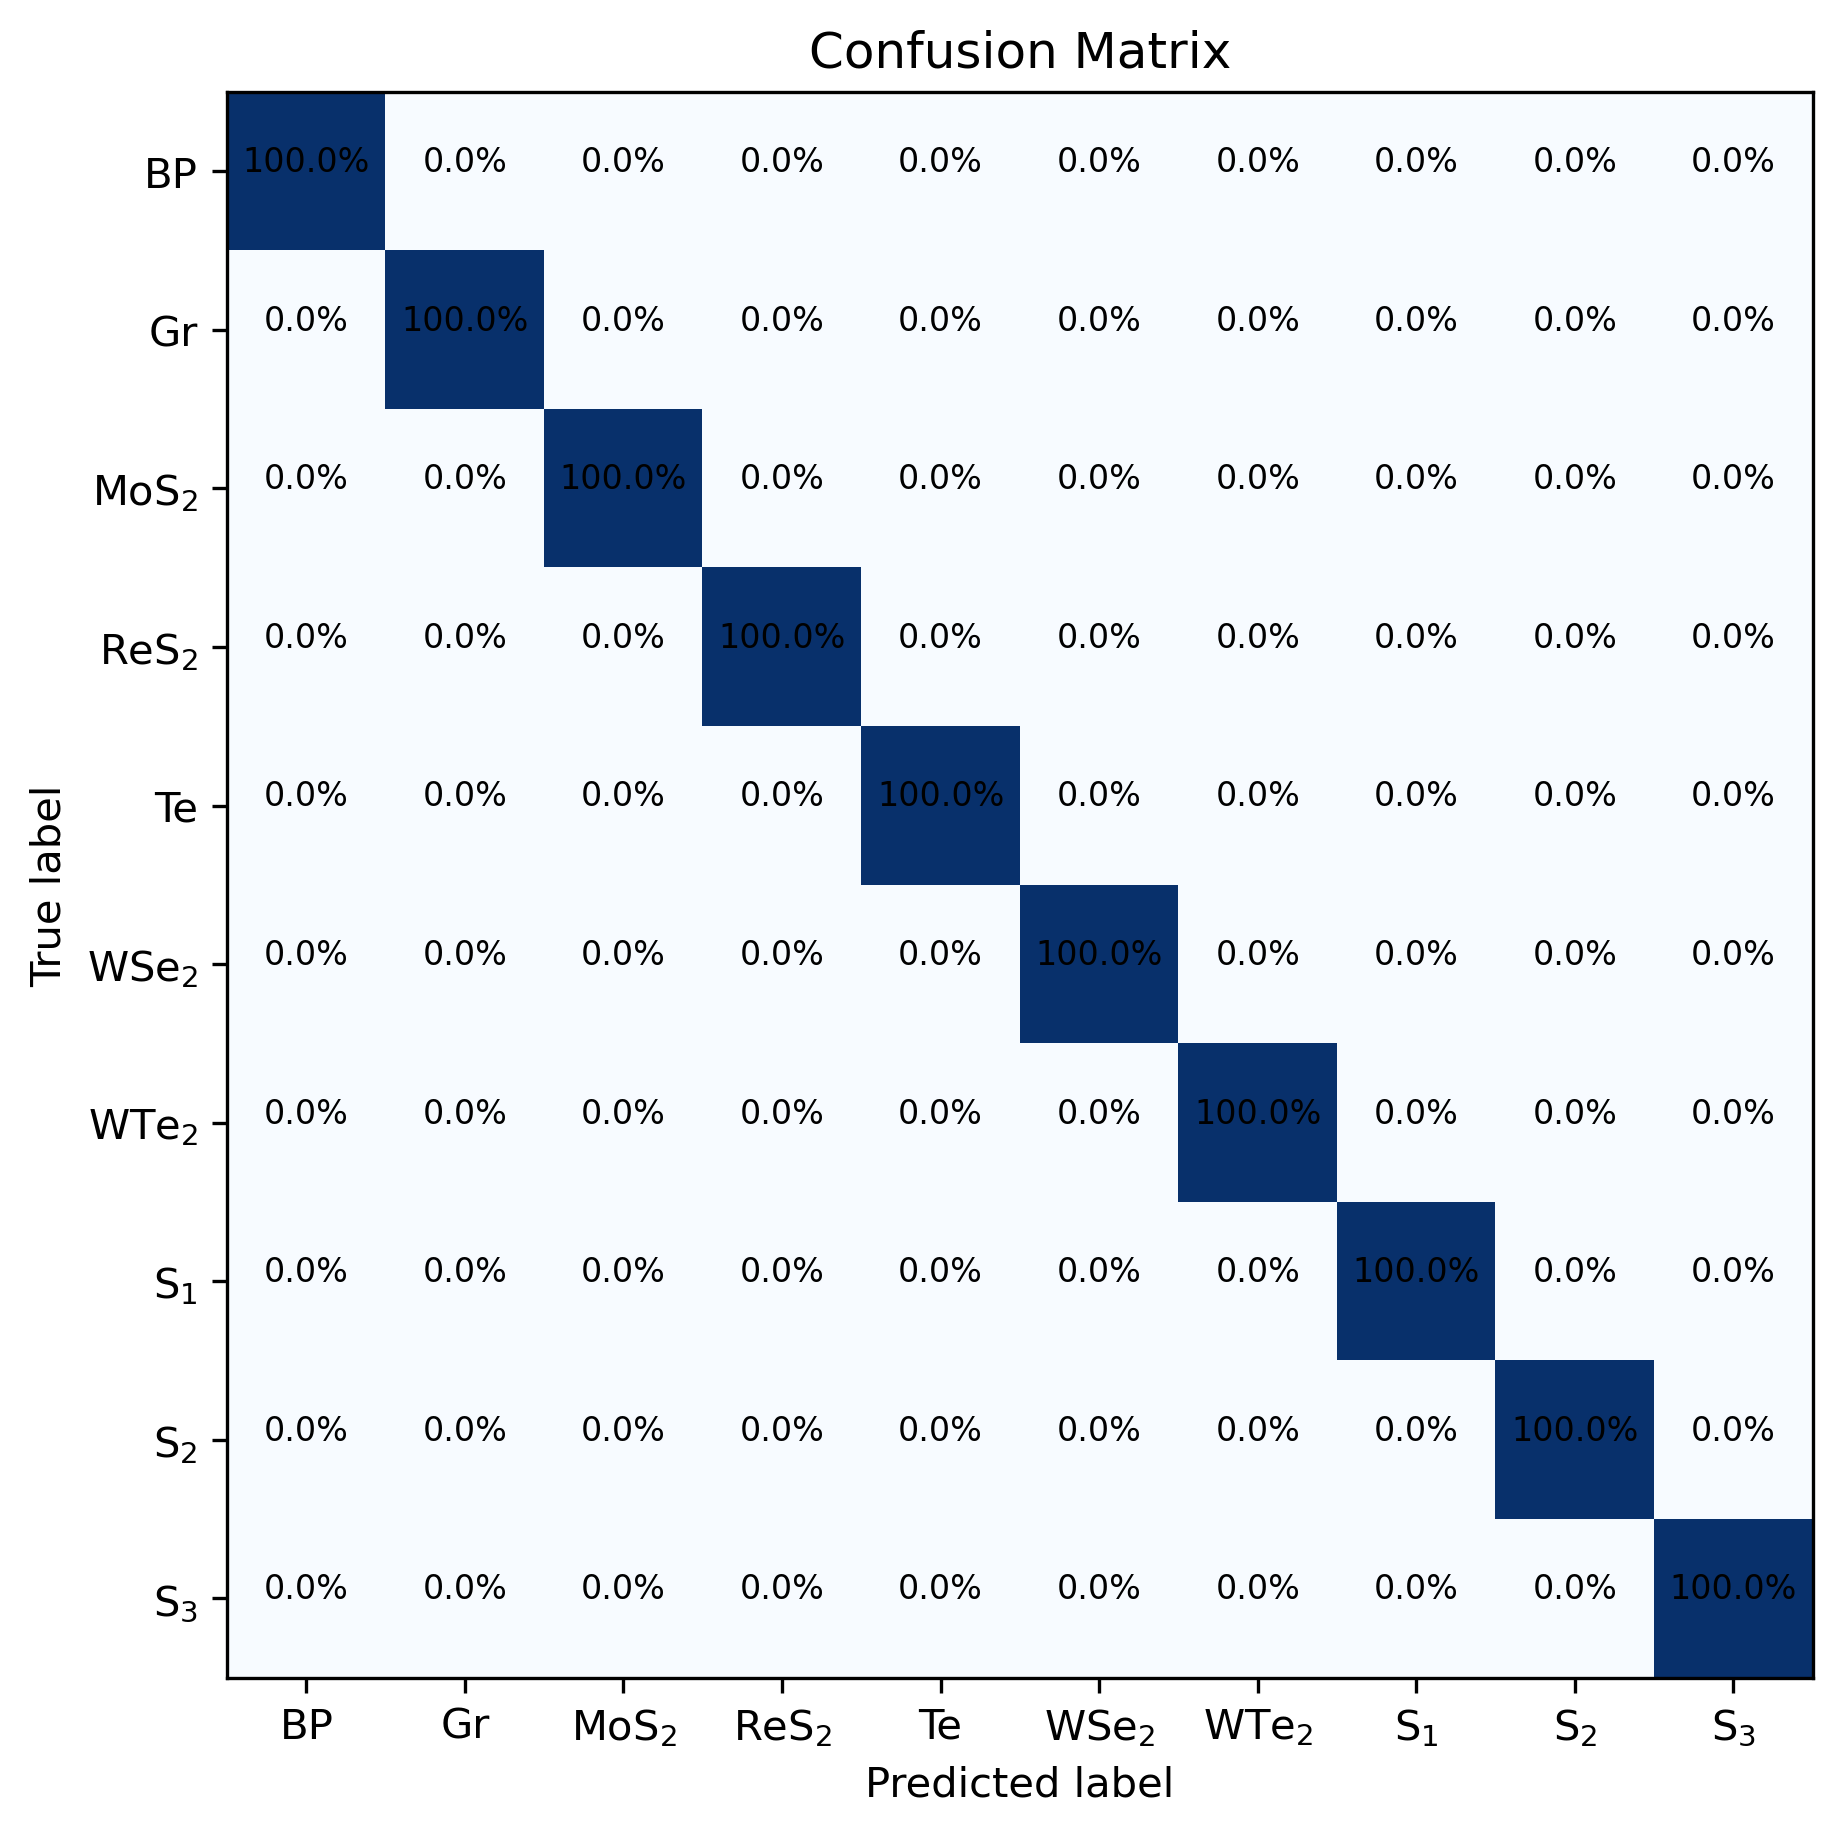

In [4]:

training(filepath, model = 'rand_for', scaler = 'robust')

TRAINING
Training model svm
Scaler: robust

CROSS-VALIDATION
Cross-validation average accuracy: 1.0
Average Precision: 1.0
Average Recall: 1.0
Average accuracy: 1.0


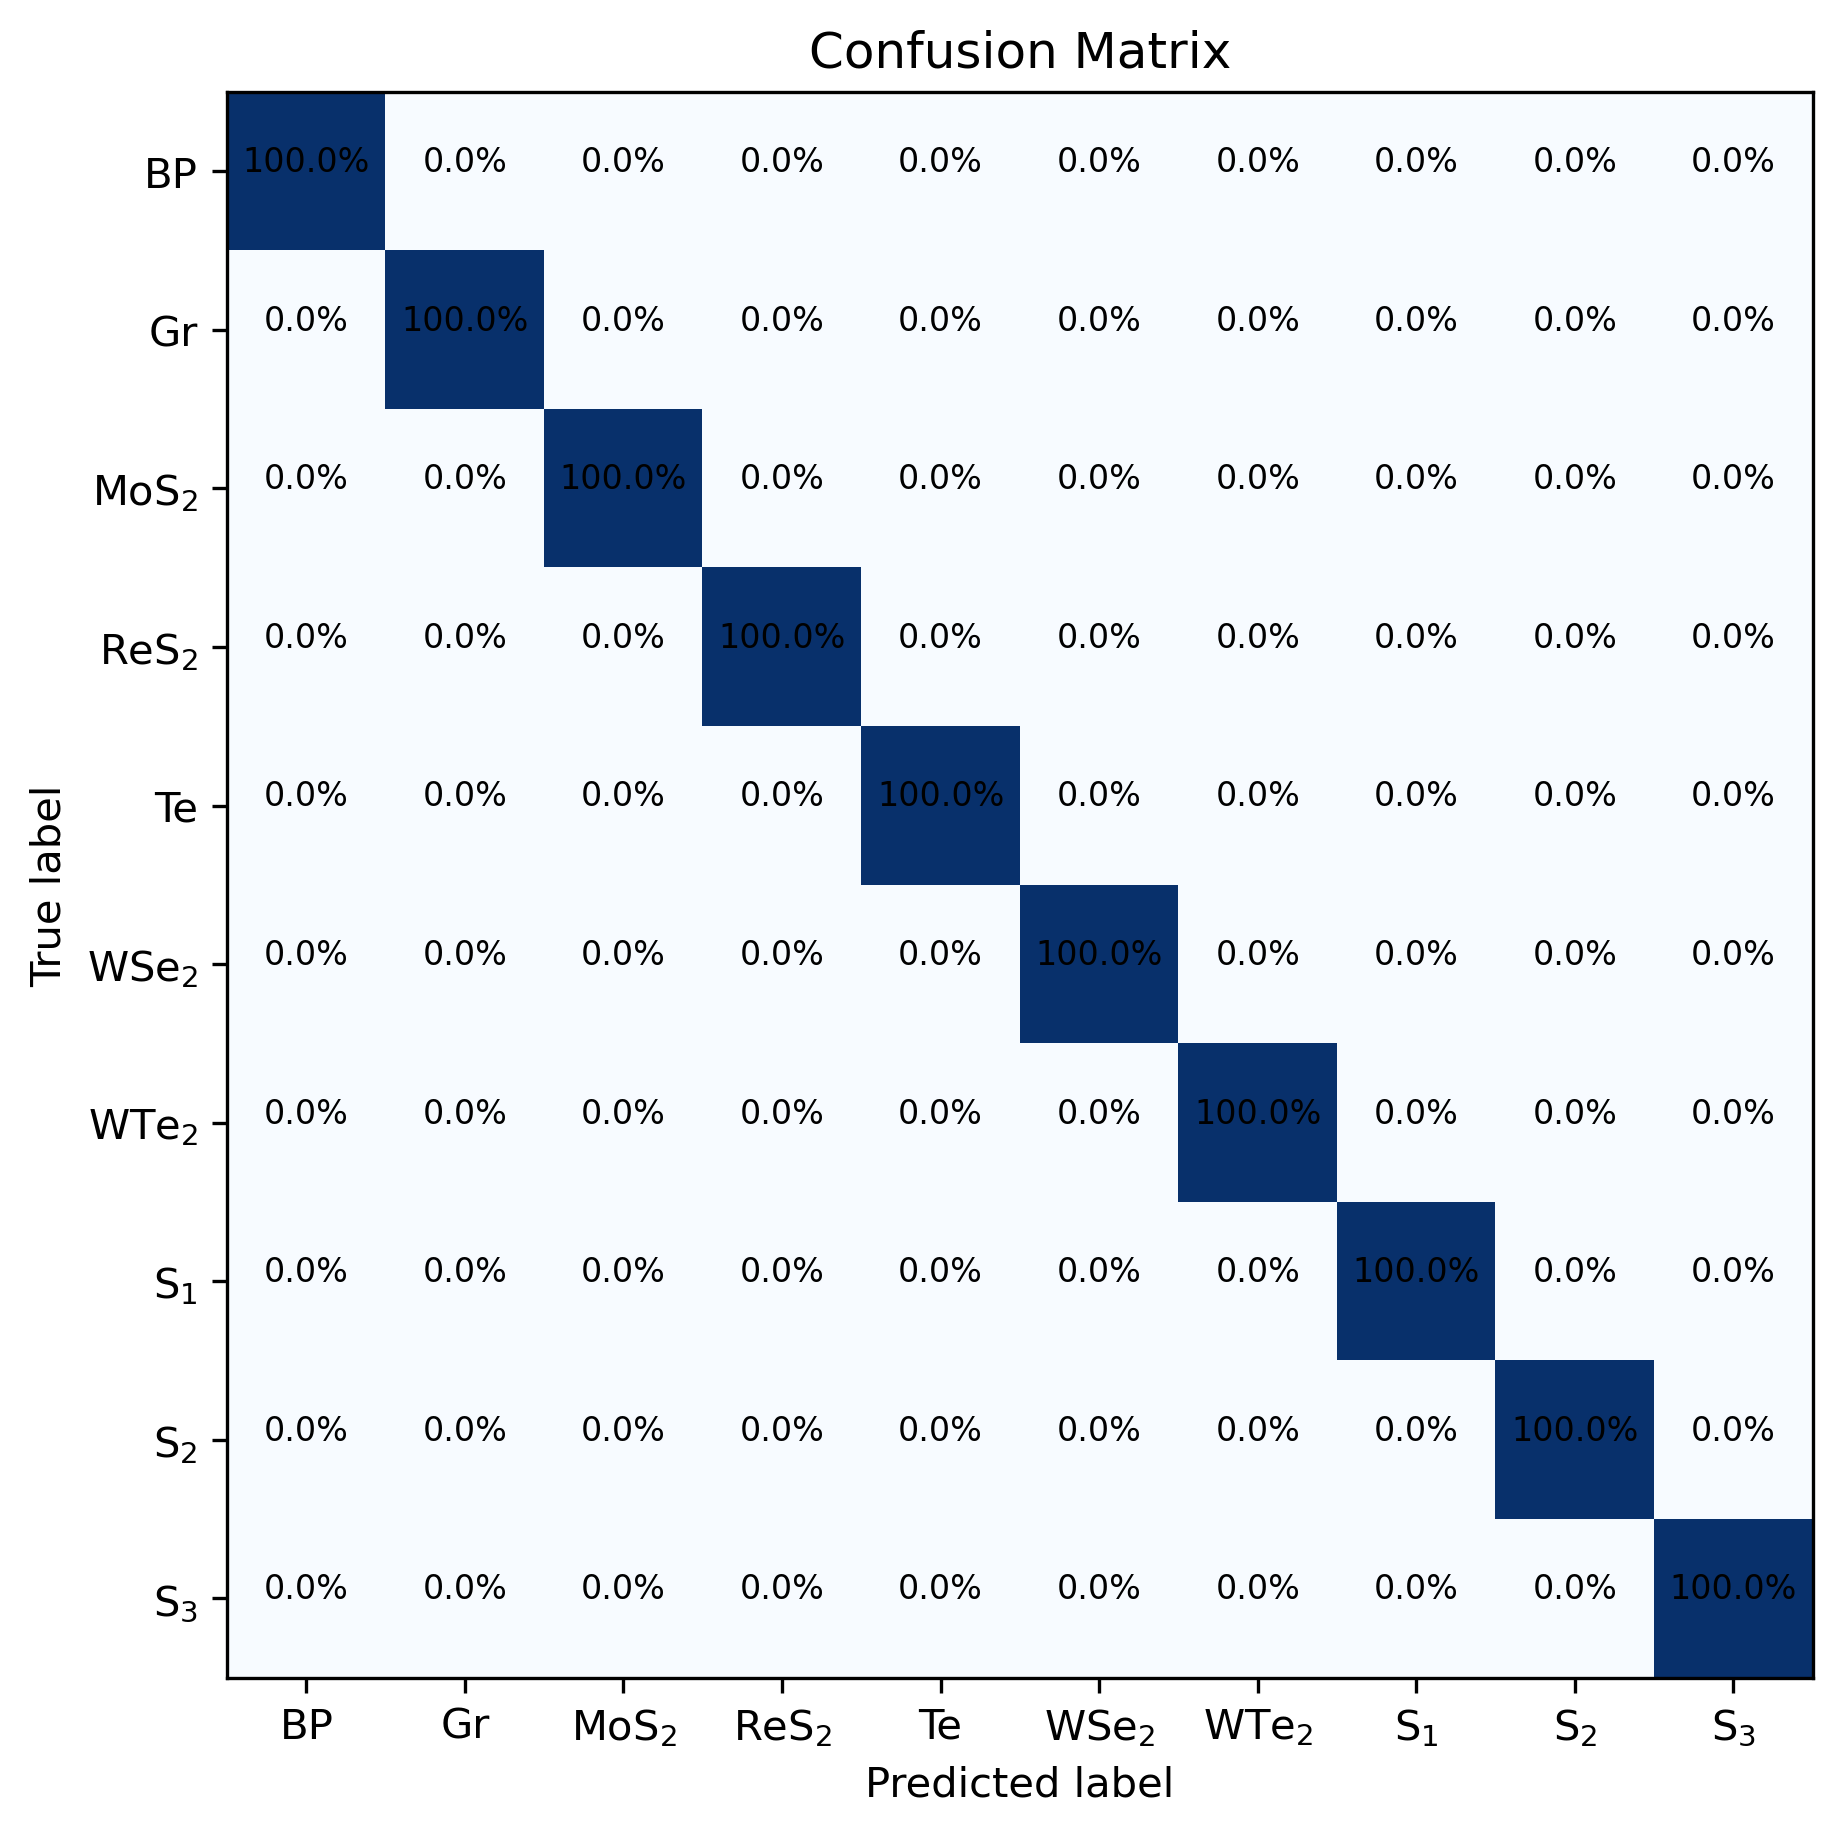

In [5]:
training(filepath, model = 'svm', scaler = 'robust')

TRAINING
Training model kneighbors
Scaler: robust

CROSS-VALIDATION
Cross-validation average accuracy: 0.9879999999999999
Average Precision: 0.9891511908052879
Average Recall: 0.9884000000000001
Average accuracy: 0.9884


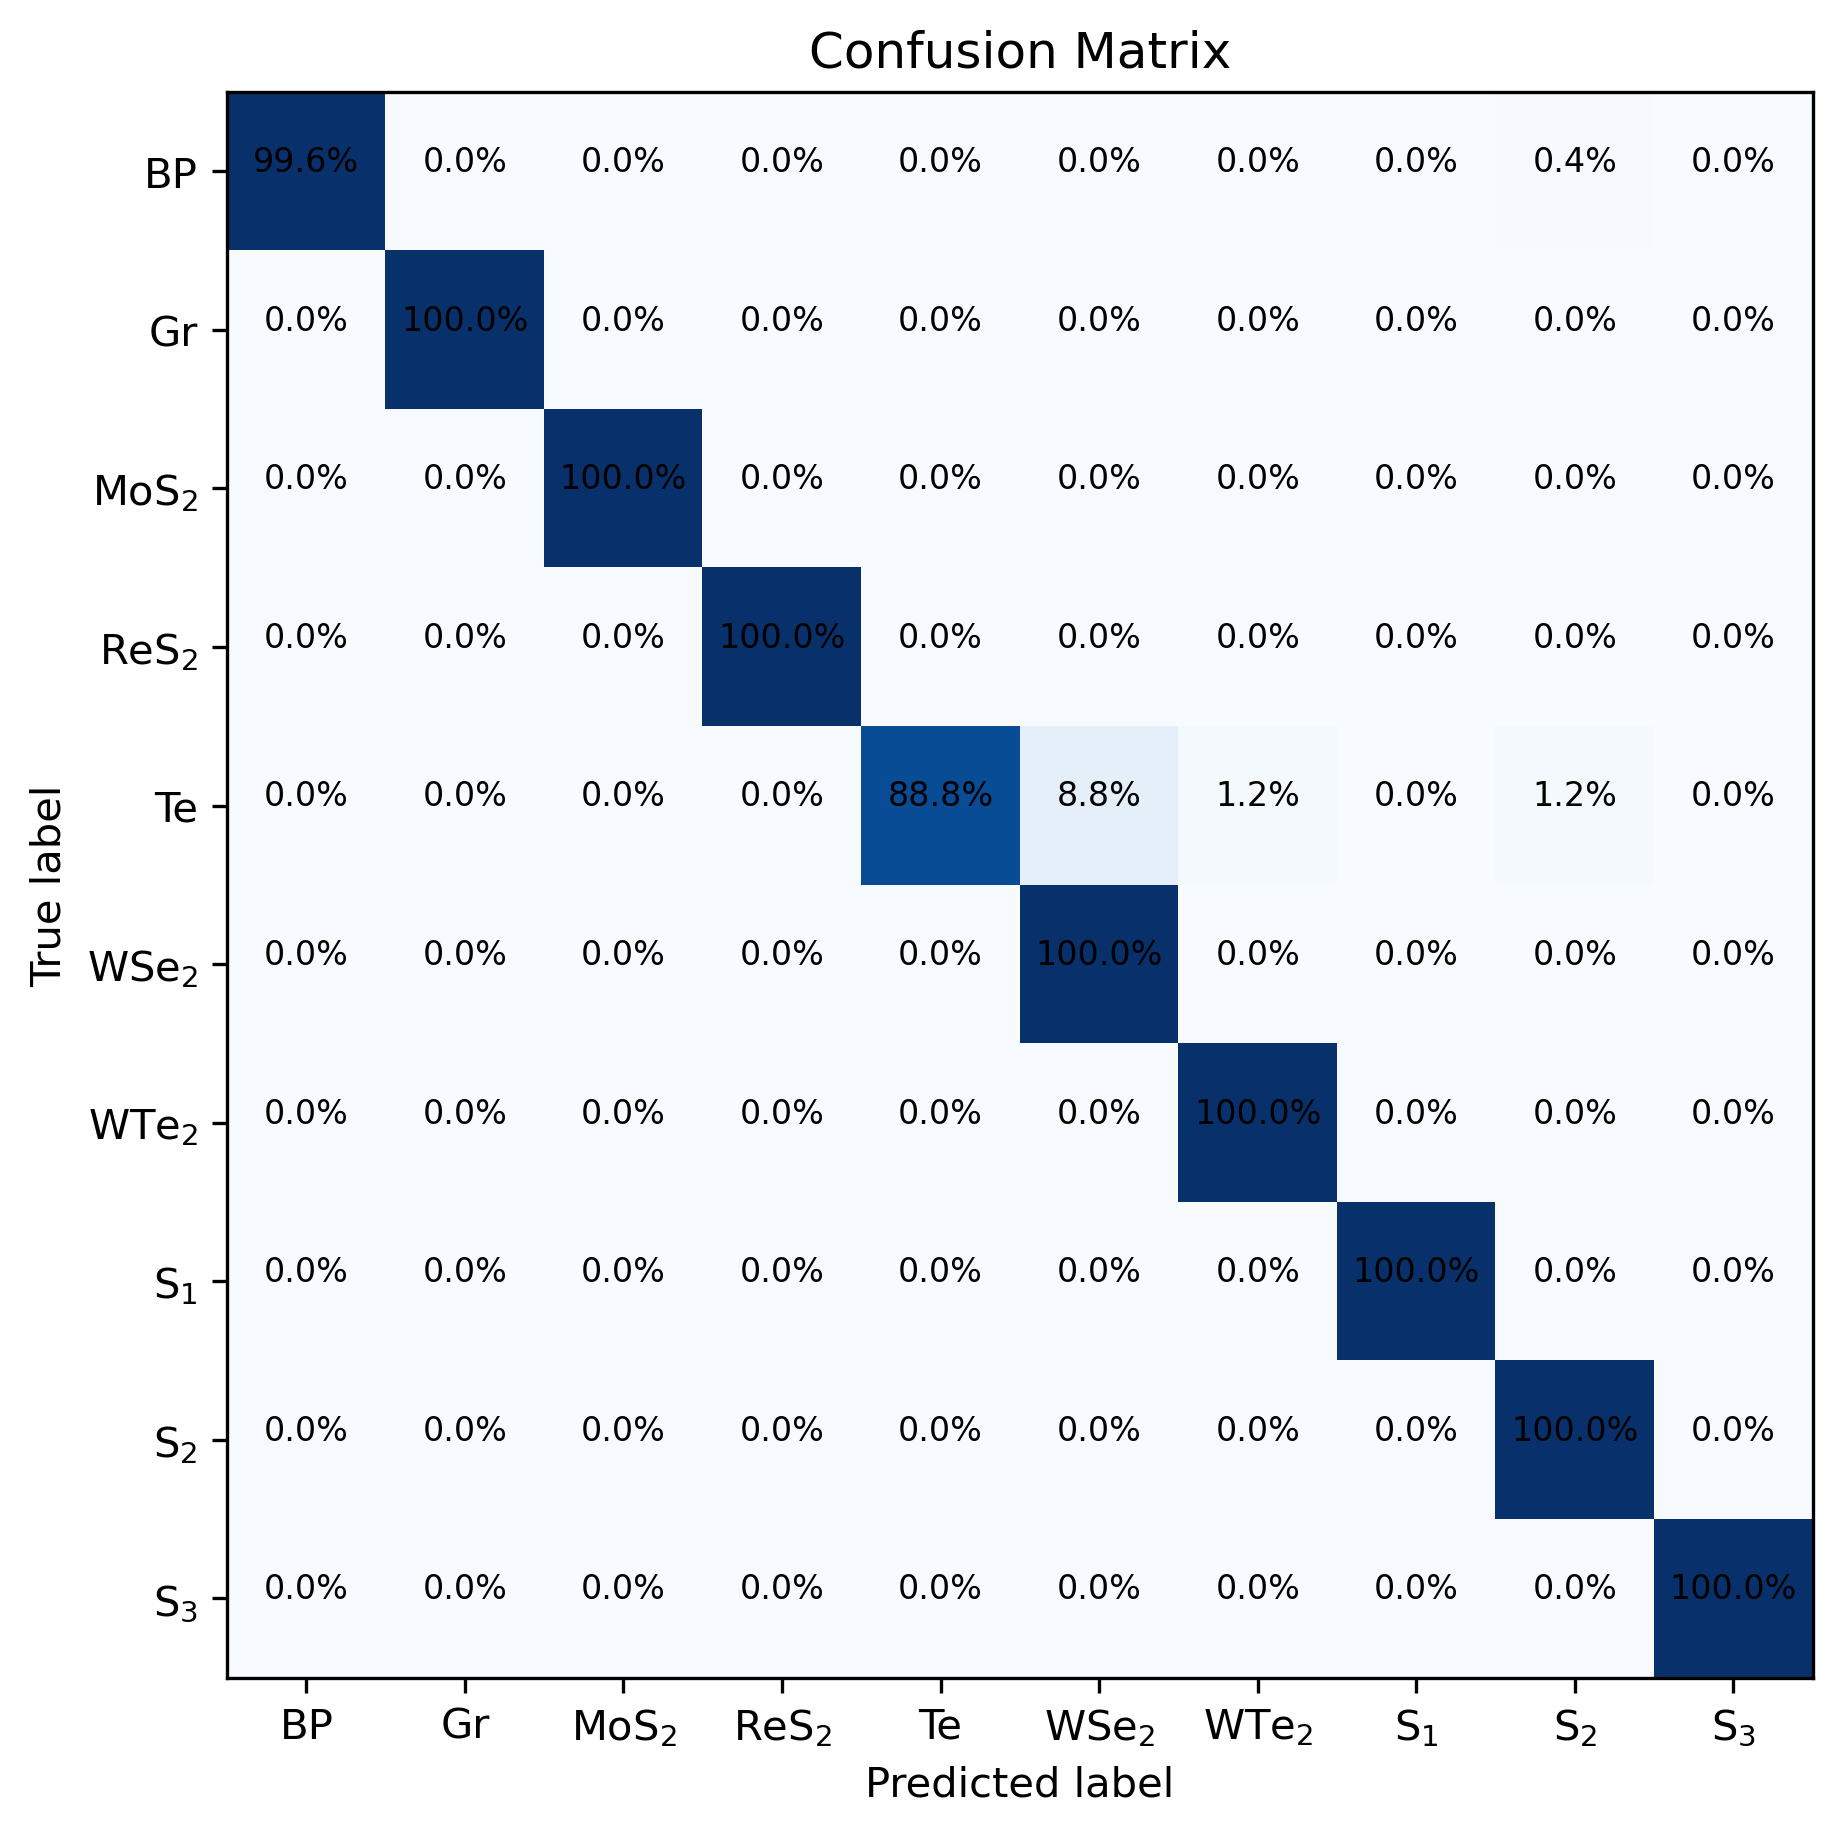

In [6]:
training(filepath, model = 'kneighbors', scaler = 'robust')

TRAINING
Training model logistic
Scaler: robust

CROSS-VALIDATION
Cross-validation average accuracy: 1.0
Average Precision: 1.0
Average Recall: 1.0
Average accuracy: 1.0


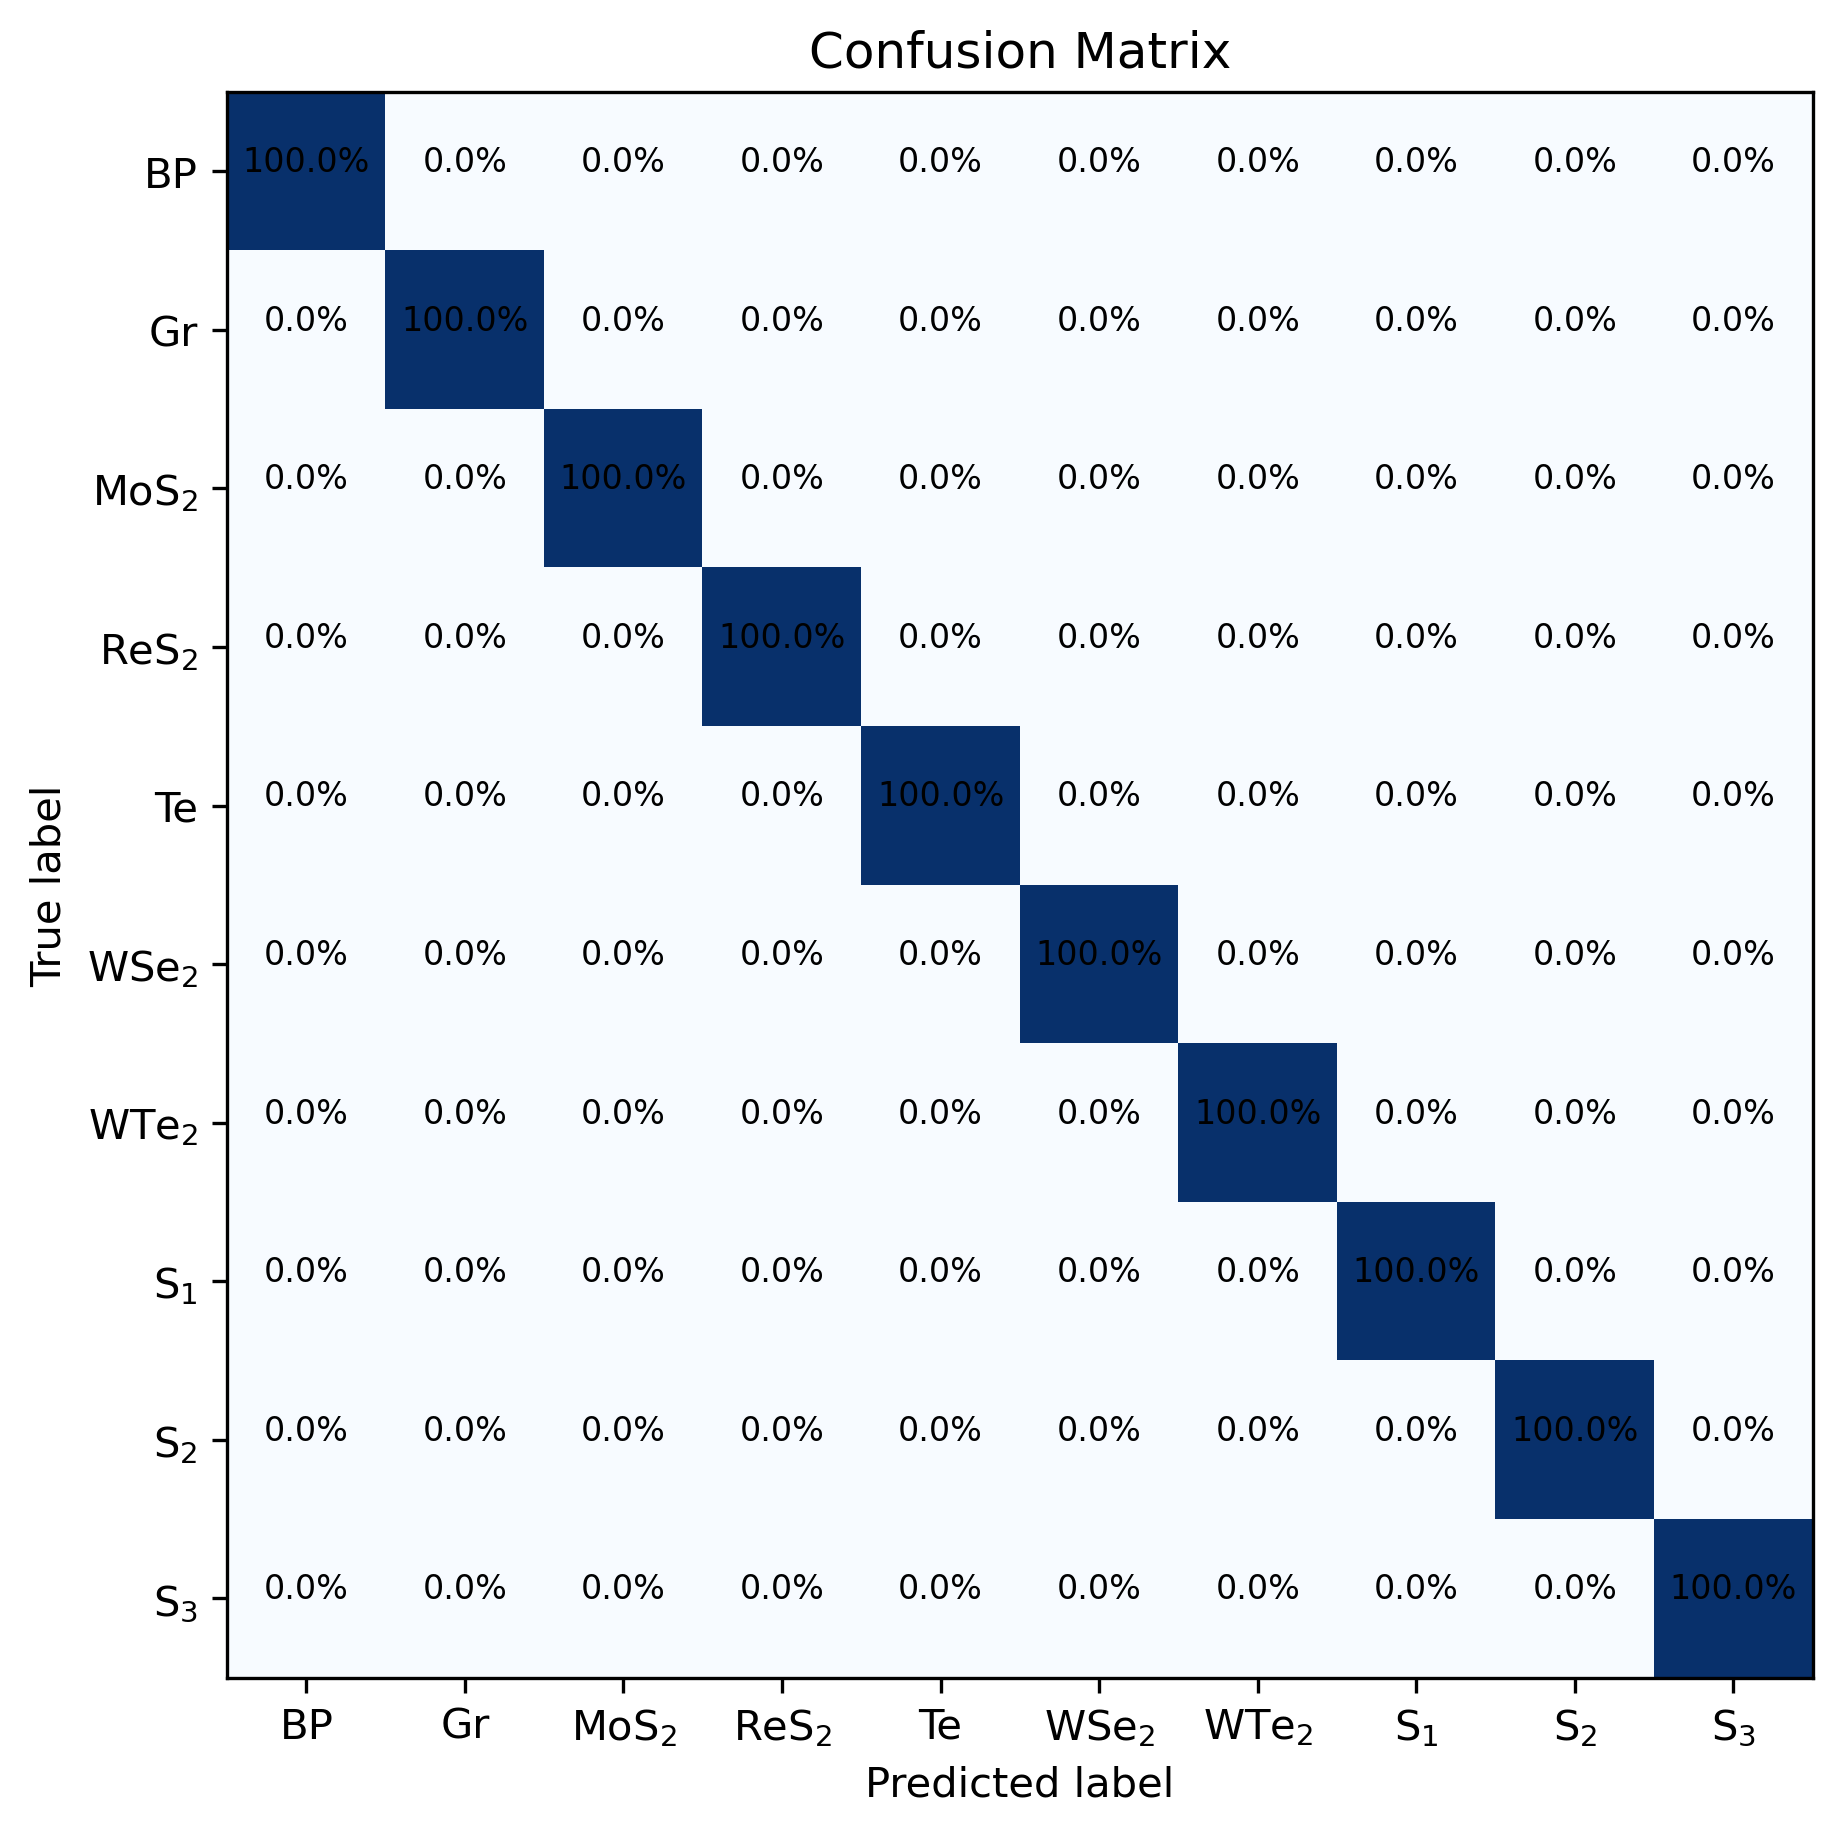

In [7]:
training(filepath, model = 'logistic', scaler = 'robust')